Рома Бохян
если вы решите запустить ноут не снижайте пожалуйста если где то будут ошибки про разные девайсы, так как я делал дз в разные дни на разных ресурсах (локально, колаб и датасфера) + у меня чуть съехало все в ноуте, я вроде пофиксил, по идее должно быть все на своем месте


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Практика по физически информированным нейронным сетям

Ориетировочняй дедлайн - 21/06/2024. Если надо будет больше времени - можно сдвинуть. Единственное ограничение - закрытие с моей стороны ведомостей.


# Задача 1 (4 балла)

Дана система дифференциальных уравнений:

$$
\frac{dx}{dt} = - \gamma x - \omega y
$$

$$
\frac{dy}{dt} = - \gamma y + \omega x
$$

Здесь $\gamma = 0.5$, $\omega = 0.5$
Начальное условие:

$$
x(0) = 1
$$

$$
y(0) = 0
$$

Обучить физически информированную нейронную сеть, которая бы аппроксимировала решение данного дифференциального уравнения при $t \in [0; 3]$: на входе - момент времени $t$, на выходе - координаты точек $x(t), y(t)$. Оцените точность обученной нейронной сети. Аргументируйте свой ответ числами/таблицами/графиками.

В качестве лосс-функции можно брать взвешенную сумму ошибок в вычислении начальных условий и выполнения дифференциального уравнения.

Ошиибка в начальных и граничных условиях (Initial and Boundary Conditions):

$$
\mathcal{L}_{IBC} = \big(x(0) - nnet_x(0)\big)^2 + \big(y(0) - nnet_y(0)\big)^2
$$

Здесь $nnet_x(t)$ и $nnet_y(t)$ - значение предсказанных нейронной сетью координат $x$ и $y$ точки в момент времени $t$

Ошибка выполнения решения дифференциального уравнения $\mathcal{L}_{DEQ}$:

$$
\mathcal{L}_{DEQ} = \sum_{i=1}^{N}\frac{1}{N} \bigg(\frac{d\ nnet_x}{dt}(t_i) + \gamma\  nnet_x(t_i) + \omega\  nnet_y(t_i)\bigg)^2 + \sum_{i=1}^{N}\frac{1}{N} \bigg(\frac{d\ nnet_y}{dt}(t_i) + \gamma\ nnet_y(t_i) - \omega\ nnet_x(t_i)\bigg)^2
$$

Здесь случайным образом генерируется $N$ точек на интервале $[0; 3]$.

Итоговая функция ошибок:

$$
\mathcal{L} = w_{IBS} \mathcal{L}_{IBS} +  w_{DEQ} \mathcal{L}_{DEQ}
$$

Веса можно использовать постоянными: например $w_{IBS} = 0.99$, $w_{DEQ} = 0.01$,
либо динамически вычисляемыми:

$$
w_{IBS} = SG\bigg(\frac{1}{1 + \exp(-\kappa \mathcal{L}_{IBS})}\bigg)
$$

$$
w_{DEQ} = SG\bigg(\frac{\exp(-\kappa \mathcal{L}_{IBS})}{1 + \exp(-\kappa \mathcal{L}_{IBS})}\bigg)
$$

Здесь $\kappa$ - настраиваемый параметр (обычно в диапазоне от 10 до 1000),
$SG$ - stop-gradient function - означает, что веса не надо дифференцировать при back-propagation.

В данном примере можно обойтись без референсных значений симулятора или точного решения.
Но если сеть обучаться не будет, то можно с некоторым весом добавить разницу с симулятором/точным решением

$$
\mathcal{L}_{SIM} = \sum_{i=1}^{N}\frac{1}{N}  \bigg(x_{ground\ truth}(t_i) - nnet_x(t_i)\bigg)^2 + \sum_{i=1}^{N}\frac{1}{N}  \bigg(y_{ground\ truth}(t_i) - nnet_y(t_i)\bigg)^2
$$

Функции, вычисляющая $x_{ground\ truth}$ и $y_{ground\ truth}$ приведены ниже.


In [27]:
%pip install numba

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


inside the main function


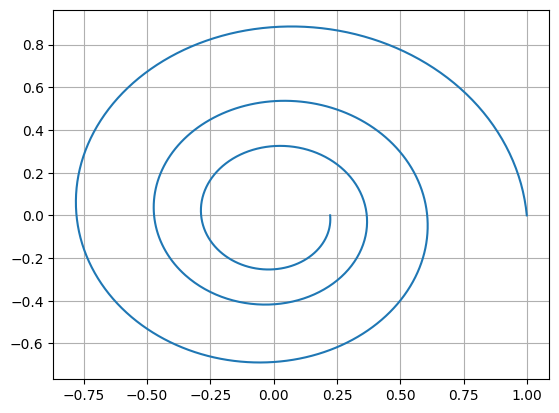

0

In [28]:
import numpy as np

import matplotlib

matplotlib.rcParams["image.cmap"] = "jet"
import matplotlib.pyplot as plt

from numba import jit

import scipy.special as sp


def compute_exact_solution(x0, t, gamma, omega):
    smat = np.zeros((t.size, 2, 2))
    smat[:, 0, 0] = +np.exp(-gamma * t) * np.cos(omega * t)
    smat[:, 0, 1] = -np.exp(-gamma * t) * np.sin(omega * t)
    smat[:, 1, 0] = +np.exp(-gamma * t) * np.sin(omega * t)
    smat[:, 1, 1] = +np.exp(-gamma * t) * np.cos(omega * t)
    return np.dot(smat, x0)


def main():
    print("inside the main function")

    t = np.linspace(0.0, 3.0, 1001)
    gamma = 0.5
    omega = 2.0 * np.pi
    x0 = np.asarray([1.0, 0.0])
    x = compute_exact_solution(x0, t, gamma, omega)
    plt.figure()
    plt.plot(x[:, 0], x[:, 1])
    plt.grid()
    plt.show()

    return 0


main()

In [29]:
gamma = 0.5
omega = 2.0 * np.pi
t_min, t_max = 0.0, 3.0


def exact_solution(t):
    x = np.exp(-gamma * t) * np.cos(omega * t)
    y = np.exp(-gamma * t) * np.sin(omega * t)
    return x, y

я решил настакать слои 256 х 256 так как двухслойка 128х128 что то не хотела аппроксимировать хорошо, еще решил взять SiLu, не знаю если честно почему, на двухслойке пробовал tanhu как активацию, но так как тот вариант не вышел я решил поменять все


In [30]:
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 256),
            nn.SiLU(),
            nn.Linear(256, 2),
        )

    def forward(self, t):
        return self.net(t)

In [31]:
def pinn_loss(model, t_interior, gamma, omega):
    t_interior = t_interior.requires_grad_()
    pred = model(t_interior)
    x = pred[:, 0:1]
    y = pred[:, 1:2]

    # производные по t
    dx_dt = torch.autograd.grad(x, t_interior, torch.ones_like(x), create_graph=True)[0]
    dy_dt = torch.autograd.grad(y, t_interior, torch.ones_like(y), create_graph=True)[0]

    # диффуп
    deq1 = dx_dt + gamma * x + omega * y
    deq2 = dy_dt + gamma * y - omega * x
    loss_deq = (deq1**2).mean() + (deq2**2).mean()

    t0 = torch.zeros((1, 1), dtype=torch.float32)
    pred0 = model(t0)
    x0_pred, y0_pred = pred0[0, 0], pred0[0, 1]
    loss_ic = (x0_pred - 1.0) ** 2 + (y0_pred - 0.0) ** 2

    loss = 0.99 * loss_ic + 0.01 * loss_deq
    return loss

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 30000
for epoch in range(n_epochs):
    t_interior = torch.FloatTensor(np.random.uniform(t_min, t_max, (128, 1))).to(device)
    loss = pinn_loss(model, t_interior, gamma, omega)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

MSE x: 1.6925e-04, MSE y: 9.4042e-05
MAE x: 9.1825e-03, MAE y: 7.5968e-03


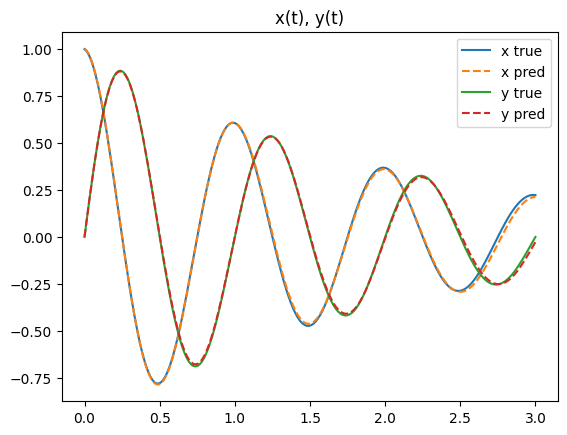

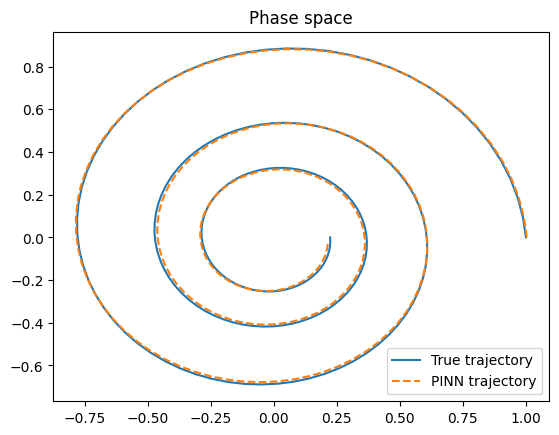

In [9]:
t_test = np.linspace(t_min, t_max, 200)
t_test_tensor = torch.FloatTensor(t_test.reshape(-1, 1)).to(device)
with torch.no_grad():
    pred = model(t_test_tensor).cpu().numpy()
x_pred, y_pred = pred[:, 0], pred[:, 1]
x_true, y_true = exact_solution(t_test)

plt.figure()
plt.plot(t_test, x_true, label="x true")
plt.plot(t_test, x_pred, "--", label="x pred")
plt.plot(t_test, y_true, label="y true")
plt.plot(t_test, y_pred, "--", label="y pred")
plt.legend()
plt.title("x(t), y(t)")

plt.figure()
plt.plot(x_true, y_true, label="True trajectory")
plt.plot(x_pred, y_pred, "--", label="PINN trajectory")
plt.legend()
plt.title("Phase space")


mse_x = np.mean((x_true - x_pred) ** 2)
mse_y = np.mean((y_true - y_pred) ** 2)
print(f"MSE x: {mse_x:.4e}, MSE y: {mse_y:.4e}")
mae_x = np.mean(abs(x_true - x_pred))
mae_y = np.mean(abs(y_true - y_pred))
print(f"MAE x: {mae_x:.4e}, MAE y: {mae_y:.4e}")

как можно заметить по метрикам обучение вышло удачным, а если на графики взглянуть то и вовсе все выходит круто, ибо нейронка смогла супер успешно аппроксимировать задачу (так как predicted and true графики наслоились друг на друга)


# Задача 2 (4 балла)

Рассмотрим квадратную мембрану (единичный квадрат) в поле тяжести.
Мембрана провисает под собственным весом, величину этого провисания и ищем в задаче.

Данную систему можно моделировать про помощи уравнения в частных производных:

$$
-\sum_{a=0}^{1} \frac{\partial}{\partial x_a} \bigg( E(p, x) \frac{\partial u}{\partial x_a}\bigg) = 1
$$

Здесь $(x_0, x_1, u(x_0, x_1)$ - координаты точки в мембраны в пространстве,
$E(p, x)$ - коэффициент упругости (ака модуль Юнга), p - вектор параметров.

Считаем, что граница мембраны зафиксирована, поэтому граничное условие:

$$
u(0, x_1) = u(1, x_1) = 0
$$

$$
u(x_0, 0) = u(x_0, 1) = 0
$$

Четыре вышеприведенных условия должны выполняться при всех $x_0, x_1 \in [0; 1]$

Коэффициент упругости меняется от одной точки на мембрне к другой по следующему закону:

$$
\log\big(E(p, x)\big) = p_0 (1 - x_0) (1 - x_1) + p_1 (1 - x_0) x_1 + p_2 x_0 (1 - x_1) + p_3 x_0 x_1
$$

Иными словами $p_0, p_1, p_2, p_3$ - значения $\log\big(E(p, x)\big)$ в вершинах квадрата.
Остальные значения вычисляются при помощи билинейной интерполяции.

В явном виде:

$$
E(p, x) = \exp\bigg(p_0 (1 - x_0) (1 - x_1) + p_1 (1 - x_0) x_1 + p_2 x_0 (1 - x_1) + p_3 x_0 x_1\bigg)
$$

По аналогии с предыдущей задачей формулируются лоссы для граничных условий
$\mathcal{L}_{IBC}$ и для дифференциального уравнения $\mathcal{L}_{DEQ}$,
Взвешивание можно использовать такое жа, как и в предыдущей задаче.

Дана система дифференциальных уравнений:

$$
\frac{dx}{dt} = - \gamma x - \omega y
$$

$$
\frac{dy}{dt} = - \gamma y + \omega x
$$

Здесь $\gamma = 0.5$, $\omega = 0.5$
Начальное условие:

$$
x(0) = 1
$$

$$
y(0) = 0
$$

Обучить физически информированную нейронную сеть, которая бы аппроксимировала решение данного дифференциального уравнения при $t \in [0; 3]$.

В качестве лосс-функции можно брать взвешенную сумму ошибок в вычислении начальных условий и выполнения дифференциального уравнения.

Альтернативный вариант - использование слабой формулировки задачи.
В таком случае, функция ошибок для дифференциального уравнения примет следующий вид:

$$
\mathcal{L}_{DEQ} = \sum_{i=1}^{N}\frac{1}{N}\bigg( \frac{1}{2} E(p_i, x_i) ||\nabla u(p_i, x_i)||^2 - u(p_i, x_i)\bigg)
$$

Здесь $x_1, ..., x_N$ - случайно сгенерированные точки из единичного квадрата,
$p_i$ - случайно сгенерированный вектор параметров из четырехмерного куба $[-1,  1] \times [-1; 1] \times [-1; 1] \times [-1; 1]$.
Заметим, что $\mathcal{L}_{DEQ}$ будет сходится к отрицательному значению.
Если нейронная сеть не будет сходится, то можно добавить функцию ошибок, вычисляющую разницу между предсказаниями
нейронной сети и симулятором (код ниже).

Требуется обучить нейронную сеть для вычисления $u$: на входе вектор параметров $p$ и вектор коориднат $x$,
на выходе $u$. Оцените точность обученной нейронной сети. Аргументируйте свой ответ числами/таблицами/графиками.


У меня была проблема что мой симулятор подсчета деформаций при моей сетке (256 на 256) генерил матрицу огромную так еще потом хранил ее и затем вызывал linalg.solve который за куб работает, в итоге я чуток поменял функции (функционал тот же) и добавил просто итеративный солвер + разреженную матрицу юзал


inside the main function


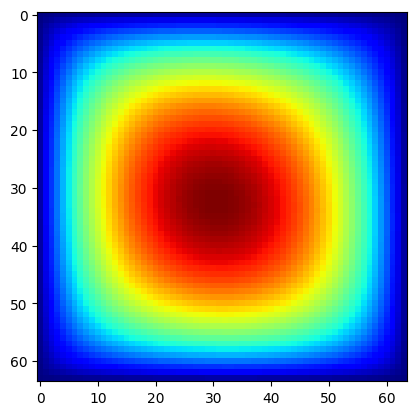

In [3]:
import numpy as np
from scipy import sparse
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import matplotlib
from numba import jit
import scipy.special as sp

matplotlib.rcParams["image.cmap"] = "jet"


def compute_flow_matrix(d_coef, dx0, dx1, dx2):
    nx0, nx1, nx2 = d_coef.shape
    nglob = nx0 * nx1 * nx2

    rows = []
    cols = []
    data = []

    def idx_glob(i0, i1, i2):
        return i2 + nx2 * i1 + nx2 * nx1 * i0

    for i0 in range(nx0):
        for i1 in range(nx1):
            for i2 in range(nx2):
                g0 = idx_glob(i0, i1, i2)
                if i0 + 1 < nx0:
                    g1 = idx_glob(i0 + 1, i1, i2)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0 + 1, i1, i2]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx1 * dx2 / dx0
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]
                if i0 - 1 >= 0:
                    g1 = idx_glob(i0 - 1, i1, i2)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0 - 1, i1, i2]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx1 * dx2 / dx0
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]
                if i1 + 1 < nx1:
                    g1 = idx_glob(i0, i1 + 1, i2)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0, i1 + 1, i2]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx2 * dx0 / dx1
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]
                if i1 - 1 >= 0:
                    g1 = idx_glob(i0, i1 - 1, i2)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0, i1 - 1, i2]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx2 * dx0 / dx1
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]
                if i2 + 1 < nx2:
                    g1 = idx_glob(i0, i1, i2 + 1)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0, i1, i2 + 1]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx0 * dx1 / dx2
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]
                if i2 - 1 >= 0:
                    g1 = idx_glob(i0, i1, i2 - 1)
                    dc0 = d_coef[i0, i1, i2]
                    dc1 = d_coef[i0, i1, i2 - 1]
                    v = 2 * dc0 * dc1 / (dc0 + dc1) * dx0 * dx1 / dx2
                    rows += [g0, g0]
                    cols += [g0, g1]
                    data += [v, -v]

    return np.array(rows), np.array(cols), np.array(data)


def compute_linear_system(d_coef, dx0, dx1, dx2):
    nx0, nx1, nx2 = d_coef.shape
    nglob = nx0 * nx1 * nx2

    rows, cols, data = compute_flow_matrix(d_coef, dx0, dx1, dx2)
    K = sparse.csr_matrix((data, (rows, cols)), shape=(nglob, nglob))

    diag = np.zeros(nglob)

    def idx_glob(i0, i1, i2):
        return i2 + nx2 * i1 + nx2 * nx1 * i0

    for i1 in range(nx1):
        for i2 in range(nx2):
            g = idx_glob(0, i1, i2)
            diag[g] += 2.0 * d_coef[0, i1, i2] * dx1 * dx2 / dx0
            g = idx_glob(nx0 - 1, i1, i2)
            diag[g] += 2.0 * d_coef[nx0 - 1, i1, i2] * dx1 * dx2 / dx0
    for i0 in range(nx0):
        for i2 in range(nx2):
            g = idx_glob(i0, 0, i2)
            diag[g] += 2.0 * d_coef[i0, 0, i2] * dx0 * dx2 / dx1
            g = idx_glob(i0, nx1 - 1, i2)
            diag[g] += 2.0 * d_coef[i0, nx1 - 1, i2] * dx0 * dx2 / dx1

    K = K + sparse.diags(diag)

    f = np.full(nglob, dx0 * dx1 * dx2)

    return K, f


def compute_deformation(d_coef, dx0, dx1, dx2):
    K, f = compute_linear_system(d_coef, dx0, dx1, dx2)
    u_vec = spsolve(K, f)
    return u_vec.reshape(d_coef.shape)


@jit(nopython=True, fastmath=True)
def generate_mesh(nx0, nx1):
    xdata = np.zeros((nx0, nx1, 2))
    for idx in range(nx0):
        xdata[idx, :, 1] = np.linspace(0.5 / nx1, 1.0 - 0.5 / nx1, nx1)
    for idx in range(nx1):
        xdata[:, idx, 0] = np.linspace(0.5 / nx0, 1.0 - 0.5 / nx0, nx0)
    return xdata


@jit(nopython=True, fastmath=True)
def compute_elasticity(param, nx0, nx1):
    xmesh = generate_mesh(nx0, nx1)
    diff_coef = np.zeros((nx0, nx1))
    diff_coef += param[0] * (1.0 - xmesh[:, :, 0]) * (1.0 - xmesh[:, :, 1])
    diff_coef += param[1] * (1.0 - xmesh[:, :, 0]) * (xmesh[:, :, 1])
    diff_coef += param[2] * (xmesh[:, :, 0]) * (1.0 - xmesh[:, :, 1])
    diff_coef += param[3] * (xmesh[:, :, 0]) * (xmesh[:, :, 1])
    return np.exp(diff_coef.reshape(nx0, nx1, 1))


def compute_deformation_value(param, nx0, nx1):
    d_coef = compute_elasticity(param, nx0, nx1)
    u = compute_deformation(d_coef, 1.0 / nx0, 1.0 / nx1, 1.0)
    return u


def main():
    print("inside the main function")
    nx0 = 64
    nx1 = 64

    param = 2.0 * np.random.rand(4) - 1.0
    u = compute_deformation_value(param, nx0, nx1)

    plt.figure()
    plt.imshow(u[:, :, 0])
    plt.show()
    return 0


main()

In [11]:
class MembranePINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(6, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
        )

    def forward(self, px):
        hat_u = self.net(px)
        x0 = px[:, 4:5]
        x1 = px[:, 5:6]
        return x0 * (1 - x0) * x1 * (1 - x1) * hat_u

In [12]:
def boundary_loss(model, p_batch, n_points=100):
    loss = 0.0
    for side in range(4):
        x = torch.rand((n_points, 2), device=p_batch.device)
        if side == 0:
            x[:, 0] = 0.0
        if side == 1:
            x[:, 0] = 1.0
        if side == 2:
            x[:, 1] = 0.0
        if side == 3:
            x[:, 1] = 1.0
        p = p_batch.repeat(n_points, 1)
        inp = torch.cat([p, x], dim=1)
        u = model(inp)
        loss += (u**2).mean()
    return loss / 4

In [13]:
def deq_loss(model, p_batch, n_points=100):
    x = torch.rand((n_points, 2), device=p_batch.device, requires_grad=True)
    p = p_batch.repeat(n_points, 1)
    inp = torch.cat([p, x], dim=1)
    u = model(inp)

    grad_u = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    du_dx0, du_dx1 = grad_u[:, 0:1], grad_u[:, 1:2]
    d2u_dx02 = torch.autograd.grad(
        du_dx0, x, torch.ones_like(du_dx0), create_graph=True
    )[0][:, 0:1]
    d2u_dx12 = torch.autograd.grad(
        du_dx1, x, torch.ones_like(du_dx1), create_graph=True
    )[0][:, 1:2]

    p0, p1, p2, p3 = p[:, 0:1], p[:, 1:2], p[:, 2:3], p[:, 3:4]
    x0, x1 = x[:, 0:1], x[:, 1:2]
    logE = (
        p0 * (1 - x0) * (1 - x1)
        + p1 * (1 - x0) * x1
        + p2 * x0 * (1 - x1)
        + p3 * x0 * x1
    )
    E = torch.exp(logE)

    dE_dx0 = torch.autograd.grad(E, x, torch.ones_like(E), create_graph=True)[0][:, 0:1]
    dE_dx1 = torch.autograd.grad(E, x, torch.ones_like(E), create_graph=True)[0][:, 1:2]
    eq = -(E * d2u_dx02 + dE_dx0 * du_dx0 + E * d2u_dx12 + dE_dx1 * du_dx1) - 1.0
    return (eq**2).mean()

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MembranePINN().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
device

device(type='cuda')

In [15]:
n_epochs = 15000
for epoch in range(n_epochs):
    p_batch = torch.FloatTensor(np.random.uniform(-1, 1, (1, 4))).to(device)
    loss_bc = boundary_loss(model, p_batch, n_points=256)  # не нужен мне больше
    loss_deq = deq_loss(model, p_batch, n_points=256)
    loss = loss_deq
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(
            f"Epoch {epoch}, Loss: {loss.item():.6f}, BC: {loss_bc.item():.6f}, DEQ: {loss_deq.item():.6f}"
        )

Epoch 0, Loss: 1.195083, BC: 0.000000, DEQ: 1.195083
Epoch 500, Loss: 0.114654, BC: 0.000000, DEQ: 0.114654
Epoch 1000, Loss: 0.194096, BC: 0.000000, DEQ: 0.194096
Epoch 1500, Loss: 0.045742, BC: 0.000000, DEQ: 0.045742
Epoch 2000, Loss: 0.044854, BC: 0.000000, DEQ: 0.044854
Epoch 2500, Loss: 0.065173, BC: 0.000000, DEQ: 0.065173
Epoch 3000, Loss: 0.016371, BC: 0.000000, DEQ: 0.016371
Epoch 3500, Loss: 0.023503, BC: 0.000000, DEQ: 0.023503
Epoch 4000, Loss: 0.083983, BC: 0.000000, DEQ: 0.083983
Epoch 4500, Loss: 0.005653, BC: 0.000000, DEQ: 0.005653
Epoch 5000, Loss: 0.005841, BC: 0.000000, DEQ: 0.005841
Epoch 5500, Loss: 0.020786, BC: 0.000000, DEQ: 0.020786
Epoch 6000, Loss: 0.008388, BC: 0.000000, DEQ: 0.008388
Epoch 6500, Loss: 0.015227, BC: 0.000000, DEQ: 0.015227
Epoch 7000, Loss: 0.002358, BC: 0.000000, DEQ: 0.002358
Epoch 7500, Loss: 0.008188, BC: 0.000000, DEQ: 0.008188
Epoch 8000, Loss: 0.006862, BC: 0.000000, DEQ: 0.006862
Epoch 8500, Loss: 0.004606, BC: 0.000000, DEQ: 0.004

In [16]:
p_test = np.array([0.5, -0.5, 0.5, -0.5])
nx, ny = 256, 256
x0 = np.linspace(0, 1, nx)
x1 = np.linspace(0, 1, ny)
X0, X1 = np.meshgrid(x0, x1, indexing="ij")
X = np.stack([X0.ravel(), X1.ravel()], axis=1)
P = np.tile(p_test, (nx * ny, 1))
inp = np.concatenate([P, X], axis=1)
inp_torch = torch.FloatTensor(inp).to(device)
with torch.no_grad():
    u_pred = model(inp_torch).cpu().numpy().reshape(nx, ny)

u_true = compute_deformation_value(p_test, nx, ny)[:, :, 0]

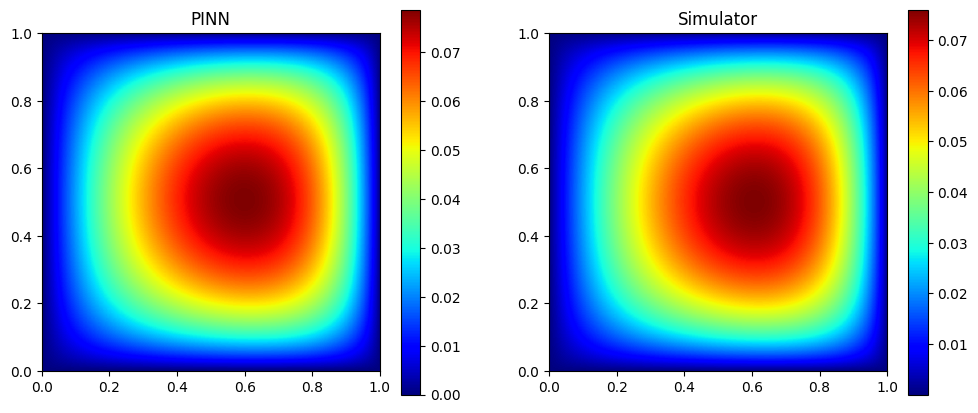

MAE: 0.0011919465017906584


In [18]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("PINN")
plt.imshow(u_pred, origin="lower", extent=[0, 1, 0, 1])
plt.colorbar()
plt.subplot(1, 2, 2)
plt.title("Simulator")
plt.imshow(u_true, origin="lower", extent=[0, 1, 0, 1])
plt.colorbar()
plt.show()

print("MAE:", np.mean(np.abs(u_pred - u_true)))

так как я вносил много изменений, я решил что напишу комментарии по коду после успешной реализации. начнем с начала - на картинке можно заметить что пинн обнулилась ровно по 4 сторонам как оригинал и никаких ям/искажений нет, картинки получились ~идентичные в том числе с максимумами, mae тут показывает 0.0012, что +- допустимо учитывая пик. Таким образом можно сказать что нейронка хорошо аппроксимировала задачу мембраны, так как и форму и амплтииду восстановила с высокой точностью.

тепреь по реализации-нужна была сетка которая возбмеь четыре паараметра жесткости + две координаты точек внутри мембраны (итого 6) и выдаст скаляр величину провисания этой мембраны в точке при заданных параметрах. я решил использовать 256х256 сетку с активацией tanh. изначально я юзал обычный матричный солвер + без разреженной матрицы и это выходило в вечную работу, поэтому как я сказал в начале я решил чуток поменять и добавить изменений для эффективности. потом я запустил код со штрафом boundary_loss и невязку pde, но граничных условий видимо было мало ибо по краям было все криво косо. поэтому я решил не юзать boundary loss (хоть я его и вывожу, я просто забыл убрать). вместо этого я использую подход trial-функцию (так ее прозвал чатгпт по правильному), то есть вот задача найти решенея от функции u(x0,x1) так что на границе квадрата [0,1]^2 будут нули типа u(0,x1)=..=u(x0,1)= 0 поэтому можно взять выход сетки и домножить на x0(1-x0)x1(1-x1) и тогда всегда будет ноль на границе, но как я понял это не противоречит заданию, то есть я все еще минимизирую невязку pde и моя множитель не добавлять каких то новых условий в уравение + это просто аля более строгий штраф и сетка все еще апроксимирует решение и обучается (то есть все ок)


# Задача 3 (2 балла)

Рассмотрим нелинейную диффузию на единичном квадрате на плоскости.
Уравнение диффузии:

$$
\frac{\partial \rho}{\partial t} = \Delta_x P(\rho)
$$

Здесь $\rho(t, x_0, x_1)$ - плотность (газа) в точке $(x_0, x_1)$ в момент времени $t$,
$P(\rho)$ - давление при заданной плотности, $\Delta_x$ - оператор Лапласа (след Гессиана).

В данном примере будем считать, что:

$$
P = \rho^\gamma
$$

Здесь $\gamma$ - параметр. Будем считать, что $\gamma = 1.4$

Начальные условия:

$$
\rho(0, x_0, x_1) = \frac{1}{1 + 10 \big((x_0 - 1/2)^2 + (x_0 - 1/2)^2\big)}
$$

В силу симметрии задачи, доступны два варианта граничных условий.
Первый вариант - непроницаемые границы (градиент перпендикулярен нормали к границе)

$$
\langle n, \nabla_x \rho \rangle = 0
$$

Здесь $n$ - вектор нормали к границе. Вышеприведенное равенство должно выполняться во всех точках границы
(на каждой стороне квадрата).

Второй вариант - периодические граничные условия:

$$
\rho(t, x_0 + 1, x_1) - \rho(t, x_0, x_1)= \rho(t, x_0, x_1 + 1) - \rho(t, x_0, x_1)= 0
$$

В последнем случае равенство можно проверять не на границе, а во всех точках единичного квадрата.

Сформулируйте функции ошибок для обучения нейронной сети, и обучите ее для вычисления $\rho(t, x_0, x_1)$
при $t \in [0; 1]$, $x_0 \in [0; 1]$, $x_1 \in [0; 1]$. Оцените точность аппроксимации путем сравнения
с симулятором (код ниже). Аргументируйте свой ответ числами/таблицами/графиками.


тут тоже столкнулся с долгими подсчтами поэтому юзанул оптимизацию как выше

inside the main function


Simulating with nx=64: 100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


0.43835979712663226
0.4528133242351787


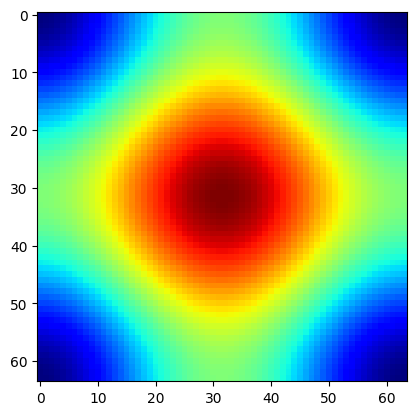

0

In [21]:
import numpy as np

import matplotlib
matplotlib.rcParams['image.cmap'] = 'jet'
import matplotlib.pyplot as plt
from tqdm import trange

from numba import jit
from scipy.sparse import lil_matrix, csr_matrix
from scipy.sparse.linalg import spsolve

import scipy.special as sp
@jit(nopython=True, fastmath=True)
def generate_mesh(nx0, nx1):
    xdata = np.zeros((nx0, nx1, 2))
    for idx in range(nx0):
        xdata[idx, :, 1] = np.linspace(0.5 / nx1, 1.0 - 0.5 / nx1, nx1)
    for idx in range(nx1):
        xdata[:, idx, 0] = np.linspace(0.5 / nx0, 1.0 - 0.5 / nx0, nx0)
    return xdata


@jit(nopython=True, fastmath=True)
def init_density(xmesh):
    return 1.0 / (1.0 + 10.0 * np.sum((xmesh - 0.5)**2, axis=2))


@jit(nopython=True, fastmath=True)
def compute_pressure(rho, gamma=1.4):
    return rho**gamma


@jit(nopython=True, fastmath=True)
def compute_dpdrho(rho, gamma=1.4):
    return gamma * (rho ** (gamma - 1.0))



def compute_t_matrix_sparse(dt, nx):
    dx = 1.0 / nx
    n = nx * nx
    tmat = lil_matrix((n, n))

    for idx0 in range(nx):
        for idx1 in range(nx):
            idx_glob0 = idx1 + nx * idx0
            diag_val = 0
            if idx0 < (nx - 1):
                idx_glob1 = idx1 + nx * (idx0 + 1)
                tmat[idx_glob0, idx_glob1] = -1.0
                diag_val += 1.0
            if idx0 > 0:
                idx_glob1 = idx1 + nx * (idx0 - 1)
                tmat[idx_glob0, idx_glob1] = -1.0
                diag_val += 1.0
            if idx1 < (nx - 1):
                idx_glob1 = idx1 + 1 + nx * idx0
                tmat[idx_glob0, idx_glob1] = -1.0
                diag_val += 1.0
            if idx1 > 0:
                idx_glob1 = idx1 - 1 + nx * idx0
                tmat[idx_glob0, idx_glob1] = -1.0
                diag_val += 1.0

            tmat[idx_glob0, idx_glob0] = diag_val

    return (dt / dx / dx) * tmat.tocsc()


def compute_newton_iteration_update_sparse(rho_curr, rho_prev, tmat_sparse):
    pres = compute_pressure(rho_curr)
    r1 = rho_curr.flatten()
    r0 = rho_prev.flatten()
    p1 = pres.flatten()
    c1 = compute_dpdrho(r1)
    from scipy.sparse import diags

    smat = diags(c1) * tmat_sparse
    smat += diags(np.ones(r1.shape[0]))

    yvec = r0 - r1 - tmat_sparse.dot(p1)

    xvec = spsolve(smat, yvec)

    return rho_curr + np.reshape(xvec, rho_curr.shape)


def compute_numerical_solution_sparse(t_final, nx, nt, n_newton):
    dt = t_final / nt
    xmesh = generate_mesh(nx, nx)
    tmat = compute_t_matrix_sparse(dt, nx)
    rho0 = init_density(xmesh)
    rho1 = rho0.copy()

    for kt in trange(nt, desc=f"Simulating with nx={nx}"):
        for k_newton in range(n_newton):
            rho1 = 0.0 + compute_newton_iteration_update_sparse(rho1, rho0, tmat)
        rho0 = 0.0 + rho1
    return rho1, xmesh


def main():
    print("inside the main function")
    t_final = 0.1
    n_newton = 6
    nx = 64  
    nt = 100
    rho, xmesh = compute_numerical_solution_sparse(t_final, nx, nt, n_newton)
    print(np.min(rho))
    print(np.max(rho))

    plt.figure()
    plt.imshow(rho[:, :])
    plt.show()

    return 0
main()

In [22]:
gamma = 1.4
t_final = 0.1
nx_sim = 64
nt_sim = 100
n_newton = 6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
class DiffusionPINN(nn.Module):
    def __init__(self, hidden_dim=128, n_layers=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.Softplus(),
            *(
                layer
                for _ in range(n_layers - 1)
                for layer in (nn.Linear(hidden_dim, hidden_dim), nn.Softplus())
            ),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid(),
        )


    def forward(self, tx):
        return self.net(2.0 * tx - 1.0)

In [24]:
def sample_initial(n):
    t = torch.zeros(n, 1, device=device)
    x0 = torch.rand(n, 1, device=device)
    x1 = torch.rand(n, 1, device=device)
    return torch.cat([t, x0, x1], dim=1)


def sample_collocation(n):
    t = torch.rand(n, 1, device=device)
    x0 = torch.rand(n, 1, device=device)
    x1 = torch.rand(n, 1, device=device)
    return torch.cat([t, x0, x1], dim=1)


def sample_periodic_bc(n):
    t = torch.rand(n, 1, device=device)
    x = torch.rand(n, 1, device=device)
    return (
        torch.cat([t, torch.zeros_like(x), x], dim=1),
        torch.cat([t, torch.ones_like(x), x], dim=1),
        torch.cat([t, x, torch.zeros_like(x)], dim=1),
        torch.cat([t, x, torch.ones_like(x)], dim=1),
    )
def initial_condition(x0, x1):
    return 1.0 / (1.0 + 10.0 * ((x0 - 0.5) ** 2 + (x1 - 0.5) ** 2))

In [25]:
def loss_initial(model, n=200):
    pts = sample_initial(n)
    pred = model(pts)
    with torch.no_grad():
        x0 = pts[:, 1:2].cpu().numpy()
        x1 = pts[:, 2:3].cpu().numpy()
        true = torch.from_numpy(initial_condition(x0, x1)).to(device)
    return nn.MSELoss()(pred, true)


def loss_pde(model, n=200):
    pts = sample_collocation(n).requires_grad_(True)
    rho = model(pts)
    grad = torch.autograd.grad(rho, pts, torch.ones_like(rho), create_graph=True)[0]
    drho_dt = grad[:, 0:1]

    P = rho**gamma
    gradP = torch.autograd.grad(P, pts, torch.ones_like(P), create_graph=True)[0]
    d2Pdx0 = torch.autograd.grad(
        gradP[:, 1:2], pts, torch.ones_like(gradP[:, 1:2]), create_graph=True
    )[0][:, 1:2]
    d2Pdx1 = torch.autograd.grad(
        gradP[:, 2:3], pts, torch.ones_like(gradP[:, 2:3]), create_graph=True
    )[0][:, 2:3]
    eq = drho_dt - (d2Pdx0 + d2Pdx1)
    eq = torch.nan_to_num(eq, nan=0.0, posinf=1e2, neginf=-1e2)
    eq = torch.clamp(eq, -10.0, 10.0)
    return (eq**2).mean()


def loss_periodic_bc(model, n=100):
    b0, b1, b2, b3 = sample_periodic_bc(n)
    r0, r1 = model(b0), model(b1)
    r2, r3 = model(b2), model(b3)
    return ((r0 - r1) ** 2 + (r2 - r3) ** 2).mean()

In [26]:
model = DiffusionPINN().to(device)
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)

model.apply(init_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.5, patience=300, verbose=True
)

for epoch in range(1, 8001):
    optimizer.zero_grad()

    l_ic = loss_initial(model, n=500)
    l_pde = loss_pde(model, n=2000)
    l_bc = loss_periodic_bc(model, n=500)

    w_ic = 1.0 / (l_ic.detach().sqrt() + 1e-6)
    w_pde = 1.0 / (l_pde.detach().sqrt() + 1e-6)
    w_bc = 1.0 / (l_bc.detach().sqrt() + 1e-6)
    loss = l_ic * w_ic + l_pde * w_pde + l_bc * w_bc

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
    optimizer.step()
    scheduler.step(loss)

    if epoch % 1000 == 0:
        print(
            f"Epoch {epoch:4d} | IC {l_ic:.2e} | PDE {l_pde:.2e} | BC {l_bc:.2e} | Total {loss:.2e}"
        )

Epoch 00623: reducing learning rate of group 0 to 5.0000e-04.
Epoch 00924: reducing learning rate of group 0 to 2.5000e-04.
Epoch 1000 | IC 3.87e-02 | PDE 1.10e-10 | BC 1.72e-10 | Total 1.97e-01
Epoch 01225: reducing learning rate of group 0 to 1.2500e-04.
Epoch 01526: reducing learning rate of group 0 to 6.2500e-05.
Epoch 01827: reducing learning rate of group 0 to 3.1250e-05.
Epoch 2000 | IC 3.87e-02 | PDE 4.29e-11 | BC 3.76e-12 | Total 1.97e-01
Epoch 02128: reducing learning rate of group 0 to 1.5625e-05.
Epoch 02429: reducing learning rate of group 0 to 7.8125e-06.
Epoch 02730: reducing learning rate of group 0 to 3.9063e-06.
Epoch 3000 | IC 4.24e-02 | PDE 4.06e-11 | BC 1.38e-12 | Total 2.06e-01
Epoch 03031: reducing learning rate of group 0 to 1.9531e-06.
Epoch 03332: reducing learning rate of group 0 to 9.7656e-07.
Epoch 03702: reducing learning rate of group 0 to 4.8828e-07.
Epoch 4000 | IC 3.43e-02 | PDE 4.35e-11 | BC 1.19e-12 | Total 1.85e-01
Epoch 04134: reducing learning rat

In [20]:
model 

DiffusionPINN(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): Softplus(beta=1, threshold=20)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): Softplus(beta=1, threshold=20)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): Softplus(beta=1, threshold=20)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): Softplus(beta=1, threshold=20)
    (8): Linear(in_features=128, out_features=1, bias=True)
    (9): Sigmoid()
  )
)

Simulating with nx=64: 100%|██████████| 100/100 [00:08<00:00, 11.54it/s]


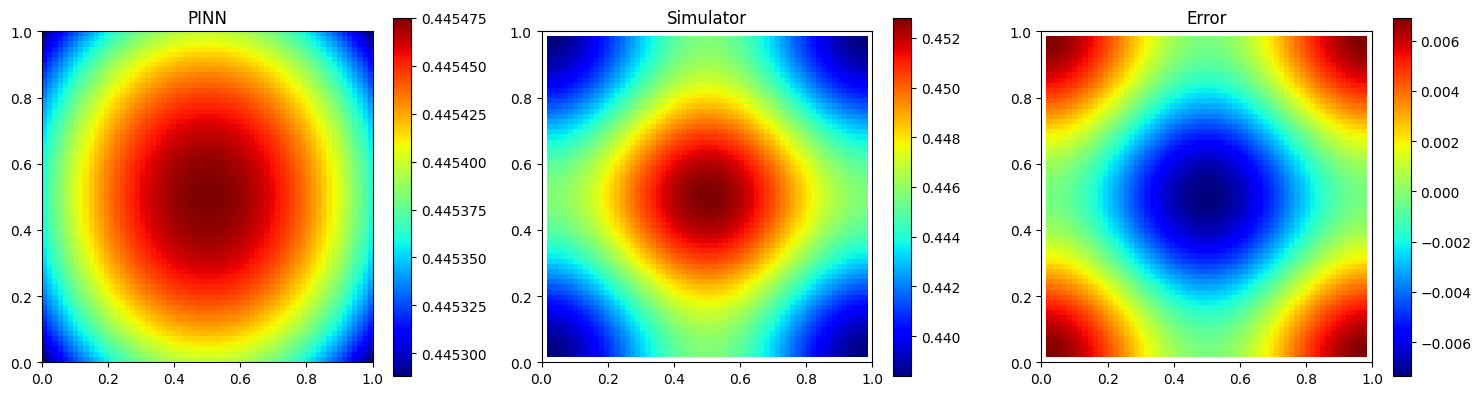

MAE: 2.895e-03
MSE: 1.270e-05


In [27]:
from scipy.interpolate import griddata

rho_sim, xmesh = compute_numerical_solution_sparse(t_final, nx_sim, nt_sim, n_newton)
x0s = xmesh[:, :, 0]
x1s = xmesh[:, :, 1]

nx_vis = 64
x0v = np.linspace(0, 1, nx_vis)
x1v = np.linspace(0, 1, nx_vis)
X0v, X1v = np.meshgrid(x0v, x1v, indexing="ij")
pts = np.column_stack([np.full(X0v.size, t_final), X0v.ravel(), X1v.ravel()])
pts_t = torch.from_numpy(pts.astype(np.float32)).to(device)

with torch.no_grad():
    rho_pinn = model(pts_t).cpu().numpy().reshape(nx_vis, nx_vis)

points = np.stack([x0s.ravel(), x1s.ravel()], axis=1)
rho_sim_i = griddata(points, rho_sim.ravel(), (X0v, X1v), method="linear")

fig, ax = plt.subplots(1, 3, figsize=(15, 4))
for a, title, arr in zip(
    ax, ("PINN", "Simulator", "Error"), (rho_pinn, rho_sim_i, rho_pinn - rho_sim_i)
):
    im = a.imshow(arr, origin="lower", extent=[0, 1, 0, 1])
    a.set_title(title)
    plt.colorbar(im, ax=a)
plt.tight_layout()
plt.show()

mse = np.nanmean((rho_pinn - rho_sim_i) ** 2)
mae = np.nanmean(np.abs(rho_pinn - rho_sim_i))
print(f"MAE: {mae:.3e}")
print(f"MSE: {mse:.3e}")

--------------------


так ну начну снова с конца-ошибка получилаьс в пределах допустимого (я бы даже сказал отличая), а по карте не все так однозначно как в прошлые разы. в центральной части квадрата моя сетка (pinn) чуть занижает сетку, а углы и края чуток завышает, но как бы видно что это все не сильно выявляется и оверолл сетка хорошо воспроизводит диффузию, чисто в теории можно еще попробовать увеличить вклад pde в центральной области, но как будто сильно не изменится ситуация, поэтому оставлю так, ну и к тому же сетка как я и сказал дает решение которое очень совпадает с численным симулятором


а теперь про то что я тут делал-я собрал pinn по 128 нейронов в каждом, между слоями стоял activation softplus, а на выходе сигмоида. входные данные (t, x0, x1) я масштабировал в диапазон [−1, 1]. модель обучалась на трёх частях потерь: mse для начального условия, невязка pde и mse для периодических граничных условий, причём веса loss-функций подбирались, чтобы сбалансировать вклад каждого компонента. обучение 8000(я как то случайно подобрал, пробовал еще 10к и 20к, но особой разницы нет)эпох с обрезкой градиента (clip_norm=5). взял softplus, потому что она гладкая и имеет непрерывные первые и вторые производные, ну и в целом такие запары использовал исключительно потому что сетка плохо обучалась, пришлось прибегать к идеям как выбить из нее максимум
